on va tenter de scrapp le wiki fandom 

In [2]:
from requests import get
import requests
from bs4 import BeautifulSoup
import re
import time
import polars as pl
from sklearn.model_selection import train_test_split
import seaborn as sns

On va essayer d'avoir tout les noms de champ d'un coup

#Récupération de data dragon riot

In [ ]:
# 1. Télécharger les données
url = "https://ddragon.leagueoflegends.com/cdn/15.24.1/data/en_US/champion.json"
response = requests.get(url)
data = response.json()

# 2. Les champions
champions_dict = data['data']

# 3On chope les infos
rows = []
for champ_name, details in champions_dict.items():
    stats = details['stats']
    info = details['info']
    rows.append({
        "Name": champ_name,
        "Class": details['tags'][0],  # On prend le rôle principal pour la classification
        "AttackRange": stats['attackrange'],
        "MoveSpeed": stats['movespeed'],

        "HP": stats['hp'],
        "HPperLevel": stats['hpperlevel'],

        "hpregen": stats['hpregen'],
        "hpregenperlevel": stats['hpregenperlevel'],

        "Armor": stats['armor'],
        "ArmorperLevel": stats['armorperlevel'],
        
        "AttackDamage": stats['attackdamage'],
        "AttackDamageperLevel": stats['attackdamageperlevel'],

        "attackspeed": stats['attackspeed'],
        "attackspeedperlevel": stats['attackspeedperlevel'],

        "Spellblock": stats['spellblock'],
        "spellblockperlevel": stats['spellblockperlevel'],

        "Prv_attack": info['attack'],
        "Prv_defense": info['defense'],
        "Prv_magic": info['magic']
    })

# 4. Créer le Tableau
tableau_champ = pl.DataFrame(rows)

print(tableau_champ)

shape: (172, 19)
┌─────────┬──────────┬────────────┬───────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ Name    ┆ Class    ┆ AttackRang ┆ MoveSpeed ┆ … ┆ spellblock ┆ Prv_attac ┆ Prv_defen ┆ Prv_magic │
│ ---     ┆ ---      ┆ e          ┆ ---       ┆   ┆ perlevel   ┆ k         ┆ se        ┆ ---       │
│ str     ┆ str      ┆ ---        ┆ i64       ┆   ┆ ---        ┆ ---       ┆ ---       ┆ i64       │
│         ┆          ┆ i64        ┆           ┆   ┆ f64        ┆ i64       ┆ i64       ┆           │
╞═════════╪══════════╪════════════╪═══════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ Aatrox  ┆ Fighter  ┆ 175        ┆ 345       ┆ … ┆ 2.05       ┆ 8         ┆ 4         ┆ 3         │
│ Ahri    ┆ Mage     ┆ 550        ┆ 330       ┆ … ┆ 1.3        ┆ 3         ┆ 4         ┆ 8         │
│ Akali   ┆ Assassin ┆ 125        ┆ 345       ┆ … ┆ 2.05       ┆ 5         ┆ 3         ┆ 8         │
│ Akshan  ┆ Marksman ┆ 500        ┆ 330       ┆ … ┆ 1.3        ┆ 0        

In [ ]:
#tableau_champ.write_csv("tableau_champ.csv", separator=";")

#Transformation du tableau pour classification 

In [4]:
# 1. On récupère d'abord la liste des classes uniques depuis ton tableau initial
classes_uniques = tableau_champ["Class"].unique().to_list()
# Correspondance 2 à 2 des roles
mapping_classes = {nom: i for i, nom in enumerate(classes_uniques)}

#On a le tableau prêt pour taffer dessus 
tableau_ml = tableau_champ.with_columns(
    pl.col("Class").replace(mapping_classes).cast(pl.Int64).alias("Target")
).drop("Name")

# 3. Affichage pour vérification
print("Dictionnaire de correspondance (pour ton rapport) :")
print(mapping_classes)
print("\nTableau prêt pour l'IA (Aperçu) :")
print(tableau_ml.head())

Dictionnaire de correspondance (pour ton rapport) :
{'Fighter': 0, 'Marksman': 1, 'Mage': 2, 'Support': 3, 'Assassin': 4, 'Tank': 5}

Tableau prêt pour l'IA (Aperçu) :
shape: (5, 19)
┌──────────┬─────────────┬───────────┬─────┬───┬────────────┬─────────────┬───────────┬────────┐
│ Class    ┆ AttackRange ┆ MoveSpeed ┆ HP  ┆ … ┆ Prv_attack ┆ Prv_defense ┆ Prv_magic ┆ Target │
│ ---      ┆ ---         ┆ ---       ┆ --- ┆   ┆ ---        ┆ ---         ┆ ---       ┆ ---    │
│ str      ┆ i64         ┆ i64       ┆ i64 ┆   ┆ i64        ┆ i64         ┆ i64       ┆ i64    │
╞══════════╪═════════════╪═══════════╪═════╪═══╪════════════╪═════════════╪═══════════╪════════╡
│ Fighter  ┆ 175         ┆ 345       ┆ 650 ┆ … ┆ 8          ┆ 4           ┆ 3         ┆ 0      │
│ Mage     ┆ 550         ┆ 330       ┆ 590 ┆ … ┆ 3          ┆ 4           ┆ 8         ┆ 2      │
│ Assassin ┆ 125         ┆ 345       ┆ 600 ┆ … ┆ 5          ┆ 3           ┆ 8         ┆ 4      │
│ Marksman ┆ 500         ┆ 330       ┆ 61

#Vérification 

In [5]:
# Vérifier le type de chaque colonne
print("Types des colonnes dans tableau_ml :")
print(tableau_ml.schema)

# Vérifier s'il reste des colonnes de type 'String'
colonnes_texte = [name for name, dtype in tableau_ml.schema.items() if dtype == pl.String]

if len(colonnes_texte) > 0:
    print(f"\n⚠️ Attention ! Il reste du texte dans : {colonnes_texte}")
else:
    print("\n✅ Parfait ! Toutes les colonnes sont numériques. Ton IA peut travailler.")

Types des colonnes dans tableau_ml :
Schema({'Class': String, 'AttackRange': Int64, 'MoveSpeed': Int64, 'HP': Int64, 'HPperLevel': Int64, 'hpregen': Float64, 'hpregenperlevel': Float64, 'Armor': Int64, 'ArmorperLevel': Float64, 'AttackDamage': Int64, 'AttackDamageperLevel': Float64, 'attackspeed': Float64, 'attackspeedperlevel': Float64, 'Spellblock': Int64, 'spellblockperlevel': Float64, 'Prv_attack': Int64, 'Prv_defense': Int64, 'Prv_magic': Int64, 'Target': Int64})

⚠️ Attention ! Il reste du texte dans : ['Class']


#Séparation

In [6]:
# 1. On chope la liste des colonnes statistiques (les "Features")
# On vire "Name", "Class" et "Target"
features_cols = [
    col for col in tableau_ml.columns 
    if col not in ["Name", "Class", "Target"]
]

# 2. On crée X (les données pour l'IA) et y (la réponse attendue)
X = tableau_ml.select(features_cols)
y = tableau_ml.select("Target")

print(f"L'IA va s'entraîner sur {len(features_cols)} caractéristiques.")
print(f"Colonnes utilisées pour X : {features_cols}")

L'IA va s'entraîner sur 17 caractéristiques.
Colonnes utilisées pour X : ['AttackRange', 'MoveSpeed', 'HP', 'HPperLevel', 'hpregen', 'hpregenperlevel', 'Armor', 'ArmorperLevel', 'AttackDamage', 'AttackDamageperLevel', 'attackspeed', 'attackspeedperlevel', 'Spellblock', 'spellblockperlevel', 'Prv_attack', 'Prv_defense', 'Prv_magic']


#Groupes d'entrainements

In [7]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y)

à Partir de là Good luck marco, on va chercher le meilleur modèle.

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
import pandas as pd
from sklearn.cluster import KMeans

On tente les chiffres ( ca va fail lamentablement )

In [ ]:
resultat = dict()

dumdum = DummyRegressor()
resultat[dumdum] = cross_val_score(dumdum, X_tr, y_tr)

lr = LinearRegression()
resultat[lr] = cross_val_score(lr, X_tr, y_tr)

la = Lasso(alpha=1.0)
resultat[la] = cross_val_score(la, X_tr, y_tr)

ri = Ridge(alpha=1.0)
resultat[ri] = cross_val_score(ri, X_tr, y_tr)

en = ElasticNet(alpha=1.0, l1_ratio=0.5)
resultat[en] = cross_val_score(en, X_tr, y_tr)

svr = SVR(C=1.0, epsilon=0.1)
resultat[svr] = cross_val_score(svr, X_tr, y_tr)

knr = KNeighborsRegressor(n_neighbors=5)
resultat[knr] = cross_val_score(knr, X_tr, y_tr)

gpr = GaussianProcessRegressor()
resultat[gpr] = cross_val_score(gpr, X_tr, y_tr)

dt = DecisionTreeRegressor()
resultat[dt] = cross_val_score(dt, X_tr, y_tr)

rf = RandomForestRegressor()
resultat[rf] = cross_val_score(rf, X_tr, y_tr)

gb = GradientBoostingRegressor()
resultat[gb] = cross_val_score(gb, X_tr, y_tr)

nn = MLPRegressor(hidden_layer_sizes=(30,), max_iter=10000)
resultat[nn] = cross_val_score(nn, X_tr, y_tr)

resultatdf = pl.from_dict(
    { str(modele): scores for modele, scores in  resultat.items()}
)

resultatdf

In [23]:
print(resultatdf.mean())

shape: (1, 12)
┌────────────┬───────────┬──────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ DummyRegre ┆ LinearReg ┆ Lasso()  ┆ Ridge()  ┆ … ┆ DecisionT ┆ RandomFor ┆ GradientB ┆ MLPRegres │
│ ssor()     ┆ ression() ┆ ---      ┆ ---      ┆   ┆ reeRegres ┆ estRegres ┆ oostingRe ┆ sor(hidde │
│ ---        ┆ ---       ┆ f64      ┆ f64      ┆   ┆ sor()     ┆ sor()     ┆ gressor() ┆ n_layer_s │
│ f64        ┆ f64       ┆          ┆          ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ize…      │
│            ┆           ┆          ┆          ┆   ┆ f64       ┆ f64       ┆ f64       ┆ ---       │
│            ┆           ┆          ┆          ┆   ┆           ┆           ┆           ┆ f64       │
╞════════════╪═══════════╪══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ -0.048706  ┆ 0.259507  ┆ 0.190697 ┆ 0.289949 ┆ … ┆ -0.304626 ┆ 0.290345  ┆ 0.11498   ┆ -11.42654 │
│            ┆           ┆          ┆          ┆   ┆           ┆           ┆

<Axes: >

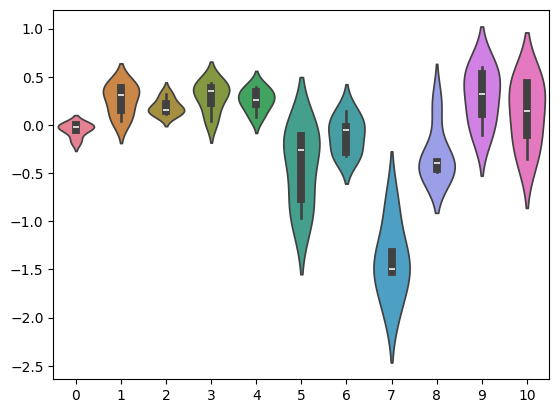

In [24]:
sns.violinplot(
    data=resultatdf.select(
        pl.exclude("MLPRegressor(hidden_layer_sizes=(30,), max_iter=10000)")
    )
)

on passe en numpy + cluster

In [33]:


# 1. Préparation des données
# Pour X : On convertit juste en Numpy (on garde les colonnes !)
X_trclean = X_tr.to_numpy() 
X_teclean = X_te.to_numpy() 

# Pour y : On convertit en Numpy ET on aplatit (.ravel)
# (On utilise y_tr car on compare avec les données d'entraînement)
y_trclean = y_tr.to_numpy().ravel()
y_teclean = y_te.to_numpy().ravel()

# 2. On lance le Clustering
kmeans = KMeans(n_clusters=6, random_state=42)
clusters_trouves = kmeans.fit_predict(X_trclean)

# 3. On compare (Attention aux noms des variables)
# On compare y_clean (la vérité) avec clusters_trouves (l'IA)
df_comparaison = pd.DataFrame({'Vrai_Role': y_trclean, 'Cluster_IA': clusters_trouves})
tableau_croise = pd.crosstab(df_comparaison['Vrai_Role'], df_comparaison['Cluster_IA'])

print("Qui est dans quel cluster ?")
print(tableau_croise)

Qui est dans quel cluster ?
Cluster_IA   0   1  2   3   4  5
Vrai_Role                       
0            0  20  2   0  13  0
1           14   0  0   8   0  0
2            5   0  0  22   1  0
3            4   1  1   7   1  1
4            1   5  0   1   5  0
5            0  10  0   0   7  0


on fait un random forest

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd

# 1. Création du modèle
# n_estimators=100 : On plante 100 arbres de décision
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Entraînement (C'est là que l'IA apprend)
# Assure-toi d'utiliser tes variables d'entraînement (X_train, y_train)
# Si tu avais nommé ça X_tr / y_tr, change les noms ici !
rf.fit(X_trclean, y_trclean)

# 3. L'Examen (Prédiction sur les données cachées)
y_pred = rf.predict(X_teclean)

# 4. Le Verdict (Score)
score = accuracy_score(y_teclean, y_pred)
print(f"🔥 Précision du modèle : {score:.2%}")

# 5. La Matrice de Confusion (Comparaison Vrai vs Prédit)
matrice = confusion_matrix(y_teclean, y_pred)

# Affichage joli avec Pandas
print("\nMatrice de Confusion (Lignes = Vrai Rôle | Colonnes = Prédiction IA) :")
print(pd.DataFrame(matrice))

🔥 Précision du modèle : 74.42%

Matrice de Confusion (Lignes = Vrai Rôle | Colonnes = Prédiction IA) :
    0  1  2  3  4  5
0  14  0  0  1  0  0
1   0  6  0  0  0  0
2   0  0  7  0  1  0
3   0  1  1  1  0  0
4   2  0  1  0  1  0
5   2  0  0  0  2  3


recherche d'hyperparamètres

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Définir le modèle
rf = RandomForestClassifier()

# Définir la grille de paramètres à tester
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Lancer la recherche
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2)
grid_search.fit(X_trclean, y_trclean)

print(f"Meilleurs paramètres : {grid_search.best_params_}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END .max_depth=1, min_samples_split=1, n_estimators=130; total time=   0.0s
[CV] END .max_depth=1, min_samples_split=1, n_estimators=130; total time=   0.0s
[CV] END .max_depth=1, min_samples_split=1, n_estimators=130; total time=   0.0s
[CV] END .max_depth=1, min_samples_split=1, n_estimators=130; total time=   0.0s
[CV] END .max_depth=1, min_samples_split=1, n_estimators=130; total time=   0.0s
[CV] END .max_depth=1, min_samples_split=1, n_estimators=140; total time=   0.0s
[CV] END .max_depth=1, min_samples_split=1, n_estimators=140; total time=   0.0s
[CV] END .max_depth=1, min_samples_split=1, n_estimators=140; total time=   0.0s
[CV] END .max_depth=1, min_samples_split=1, n_estimators=140; total time=   0.0s
[CV] END .max_depth=1, min_samples_split=1, n_estimators=140; total time=   0.0s
[CV] END .max_depth=1, min_samples_split=1, n_estimators=200; total time=   0.0s
[CV] END .max_depth=1, min_samples_split=1, n_e

C:\Users\Marc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Marc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Marc\AppData\Local\Packages\PythonSoftwareFoundation

Meilleurs paramètres : {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}


In [55]:
# Utilisation des meilleurs paramètres trouvés
rf_optimized = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    random_state=42  # Pour des résultats reproductibles
)

rf_optimized.fit(X_trclean, y_trclean)
y_predopti = rf_optimized.predict(X_teclean)
# 4. Le Verdict (Score)
scoreopti = accuracy_score(y_teclean, y_predopti)
print(f"🔥 Précision du modèle : {scoreopti:.2%}")

# 5. La Matrice de Confusion (Comparaison Vrai vs Prédit)
matriceopti = confusion_matrix(y_teclean, y_predopti)
# Affichage joli avec Pandas
print("\nMatrice de Confusion (Lignes = Vrai Rôle | Colonnes = Prédiction IA) :")
print(pd.DataFrame(matriceopti))


🔥 Précision du modèle : 76.74%

Matrice de Confusion (Lignes = Vrai Rôle | Colonnes = Prédiction IA) :
    0  1  2  3  4  5
0  14  0  0  0  1  0
1   0  6  0  0  0  0
2   0  0  7  0  1  0
3   0  1  1  1  0  0
4   2  0  1  0  1  0
5   1  0  0  0  2  4


Nouveau tableau de champ pour tester le lvl 10

In [ ]:
tableau_champ_V2 = tableau_ml.with_columns(
    (pl.col("Spellblock") + pl.col("spellblockperlevel") * 9).alias("Spellblock_lvl_10"),
    (pl.col("attackspeed") + pl.col("attackspeedperlevel") * 9).alias("attackspeed_lvl_10"),
    (pl.col("AttackDamage") + pl.col("AttackDamageperLevel") * 9).alias("AttackDamage_lvl_10"),
    (pl.col("Armor") + pl.col("ArmorperLevel") * 9).alias("Armor_lvl_10"),
    (pl.col("hpregen") + pl.col("hpregenperlevel") * 9).alias("hpregen_lvl_10"),
    (pl.col("HP") + pl.col("HPperLevel") * 9).alias("hp_lvl_10"))

tableau_champ_V2bis = tableau_champ_V2.drop(["spellblockperlevel", "attackspeedperlevel", "AttackDamageperLevel", "ArmorperLevel", "hpregenperlevel", "HPperLevel"])

In [ ]:
#tableau_champ_V2.write_csv("tableau_champV2.csv", separator=";")
#tableau_champ_V2bis.write_csv("tableau_champV2bis.csv", separator=";")

On sépare le tableau_champ_V2bis

In [71]:
features_cols_v2 = [
    col for col in tableau_champ_V2bis.columns 
    if col not in ["Name", "Class", "Target"]
]

X_v2 = tableau_champ_V2bis.select(features_cols_v2)
y_v2 = tableau_champ_V2bis.select("Target")

print(f"L'IA va s'entraîner sur {len(features_cols_v2)} caractéristiques.")
print(f"Colonnes utilisées pour X : {features_cols_v2}")

L'IA va s'entraîner sur 17 caractéristiques.
Colonnes utilisées pour X : ['AttackRange', 'MoveSpeed', 'HP', 'hpregen', 'Armor', 'AttackDamage', 'attackspeed', 'Spellblock', 'Prv_attack', 'Prv_defense', 'Prv_magic', 'Spellblock_lvl_10', 'attackspeed_lvl_10', 'AttackDamage_lvl_10', 'Armor_lvl_10', 'hpregen_lvl_10', 'hp_lvl_10']


In [72]:
X_tr_v2, X_te_v2, y_tr_v2, y_te_v2 = train_test_split(X_v2, y_v2)

Numpy puis cluster pour tenter

In [73]:
# 1. Préparation des données
# Pour X : On convertit juste en Numpy et on garde les colonnes !
X_trclean_v2 = X_tr_v2.to_numpy() 
X_teclean_v2 = X_te_v2.to_numpy() 

# Pour y : On convertit en Numpy ET on aplatit (.ravel)
# (On utilise y_tr car on compare avec les données d'entraînement)
y_trclean_v2 = y_tr_v2.to_numpy().ravel()
y_teclean_v2 = y_te_v2.to_numpy().ravel()

# 2. On lance le Clustering
kmeans_v2 = KMeans(n_clusters=6, random_state=42)
clusters_trouves_v2 = kmeans_v2.fit_predict(X_trclean_v2)

# 3. On compare (Attention aux noms des variables)
# On compare y_clean (la vérité) avec clusters_trouves (l'IA)
df_comparaison_v2 = pd.DataFrame({'Vrai_Role': y_trclean_v2, 'Cluster_IA': clusters_trouves_v2})
tableau_croise_v2 = pd.crosstab(df_comparaison_v2['Vrai_Role'], df_comparaison_v2['Cluster_IA'])

print("Qui est dans quel cluster ?")
print(tableau_croise_v2)

Qui est dans quel cluster ?
Cluster_IA   0   1   2  3  4   5
Vrai_Role                       
0           19   1  15  0  1   0
1            0  10   0  0  0  11
2            1   9   0  3  0  14
3            0   2   1  8  0   1
4            4   3   6  0  0   0
5            9   0  11  0  0   0


Random forest 

In [74]:
# 1. Création du modèle
# n_estimators=100 : On plante 100 arbres de décision
rf_v2 = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Entraînement (C'est là que l'IA apprend)
# Assure-toi d'utiliser tes variables d'entraînement (X_train, y_train)
# Si tu avais nommé ça X_tr / y_tr, change les noms ici !
rf_v2.fit(X_trclean_v2, y_trclean_v2)

# 3. L'Examen (Prédiction sur les données cachées)
y_pred_v2 = rf_v2.predict(X_teclean_v2)

# 4. Le Verdict (Score)
score_v2 = accuracy_score(y_teclean_v2, y_pred_v2)
print(f"🔥 Précision du modèle : {score_v2:.2%}")

# 5. La Matrice de Confusion (Comparaison Vrai vs Prédit)
matrice_v2 = confusion_matrix(y_teclean_v2, y_pred_v2)
# Affichage joli avec Pandas
print("\nMatrice de Confusion (Lignes = Vrai Rôle | Colonnes = Prédiction IA) :")
print(pd.DataFrame(matrice_v2))

🔥 Précision du modèle : 69.77%

Matrice de Confusion (Lignes = Vrai Rôle | Colonnes = Prédiction IA) :
    0  1  2  3  4  5
0  11  0  1  0  1  1
1   1  6  0  0  0  0
2   0  2  6  1  0  0
3   1  1  1  2  0  1
4   1  0  0  0  2  0
5   0  0  0  0  1  3


Optimisation

In [80]:
# Définir le modèle
rf_v2 = RandomForestClassifier()

# Définir la grille de paramètres à tester
param_grid = {
    'n_estimators': [100, 130, 150],#50, 100, 200
    'max_depth': [30, 40, 50],#10, 20, 30
    'min_samples_split': [10, 12, 15]#2, 5, 10
}

# Lancer la recherche
grid_search_v2 = GridSearchCV(estimator=rf_v2, param_grid=param_grid, cv=5, verbose=2)
grid_search_v2.fit(X_trclean_v2, y_trclean_v2)

print(f"Meilleurs paramètres : {grid_search_v2.best_params_}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END max_depth=30, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=30, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=30, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=30, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=30, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=30, min_samples_split=10, n_estimators=130; total time=   0.2s
[CV] END max_depth=30, min_samples_split=10, n_estimators=130; total time=   0.2s
[CV] END max_depth=30, min_samples_split=10, n_estimators=130; total time=   0.2s
[CV] END max_depth=30, min_samples_split=10, n_estimators=130; total time=   0.2s
[CV] END max_depth=30, min_samples_split=10, n_estimators=130; total time=   0.2s
[CV] END max_depth=30, min_samples_split=10, n_estimators=150; total time=   0.2s
[CV] END max_depth=30, min_samples_s

utilisation des nouveaux résultats

In [ ]:
rf_v2_optimized = RandomForestClassifier(
    **grid_search_v2.best_params_,
    random_state=42  # Pour des résultats reproductibles
)

rf_v2_optimized.fit(X_trclean_v2, y_trclean_v2)
y_predopti_v2 = rf_v2_optimized.predict(X_teclean_v2)
# 4. Le Verdict (Score)
scoreopti_v2 = accuracy_score(y_teclean_v2, y_predopti_v2)
print(f"🔥 Précision du modèle : {scoreopti_v2:.2%}")

# 5. La Matrice de Confusion (Comparaison Vrai vs Prédit)
matriceopti_v2 = confusion_matrix(y_teclean_v2, y_predopti_v2)
# Affichage joli avec Pandas
print("\nMatrice de Confusion (Lignes = Vrai Rôle | Colonnes = Prédiction IA) :")
print(pd.DataFrame(matriceopti_v2))

🔥 Précision du modèle : 74.42%

Matrice de Confusion (Lignes = Vrai Rôle | Colonnes = Prédiction IA) :
    0  1  2  3  4  5
0  10  0  1  0  2  1
1   1  6  0  0  0  0
2   0  1  7  1  0  0
3   1  0  1  3  0  1
4   1  0  0  0  2  0
5   0  0  0  0  0  4


Je vais tenter un petit XGBOOOOOOOOOOOST

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

# 1. Création du modèle
hgb = HistGradientBoostingClassifier(
    learning_rate=0.1,    # La "vitesse" d'apprentissage (réduire si ça overfit)
    max_iter=100,         # Équivalent de n_estimators (nombre d'arbres)
    max_depth=None,       # Il gère la profondeur automatiquement, ou tu peux la limiter
    random_state=42
)

# 2. Entraînement
hgb.fit(X_trclean_v2, y_trclean_v2)

y_pred_hgb = hgb.predict(X_teclean_v2)

# 4. Afficher le score
print(f"Score HGB : {hgb.score(X_teclean_v2, y_teclean_v2):.2%}")

Score HGB : 67.44%


recher d'hyper para

In [83]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# 1. Définir le modèle de base
# On active 'balanced' pour aider tes classes 3, 4 et 5
hgb = HistGradientBoostingClassifier(class_weight='balanced', random_state=42)

# 2. Définir la grille de paramètres
# Note : C'est une grille "intelligente" pour ne pas que ça dure des heures
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200, 300],       # Combien d'arbres ?
    'max_leaf_nodes': [31, 63, None],  # Complexité de l'arbre (None = illimité)
    'l2_regularization': [0, 1.5],     # Pour éviter le sur-apprentissage
    'max_depth': [None, 10]            # Optionnel, souvent max_leaf_nodes suffit
}

# 3. Lancer la recherche
# n_jobs=-1 utilise tous les cœurs de ton processeur pour aller plus vite
grid_search_hgb = GridSearchCV(hgb, param_grid, cv=5, verbose=1, n_jobs=-1)

print("Recherche des meilleurs paramètres en cours...")
grid_search_hgb.fit(X_trclean_v2, y_trclean_v2)

print(f"Meilleurs paramètres : {grid_search_hgb.best_params_}")
print(f"Meilleur score de validation : {grid_search_hgb.best_score_:.2%}")

Recherche des meilleurs paramètres en cours...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Meilleurs paramètres : {'l2_regularization': 0, 'learning_rate': 0.01, 'max_depth': None, 'max_iter': 200, 'max_leaf_nodes': 31}
Meilleur score de validation : 75.26%


meilleure recherche

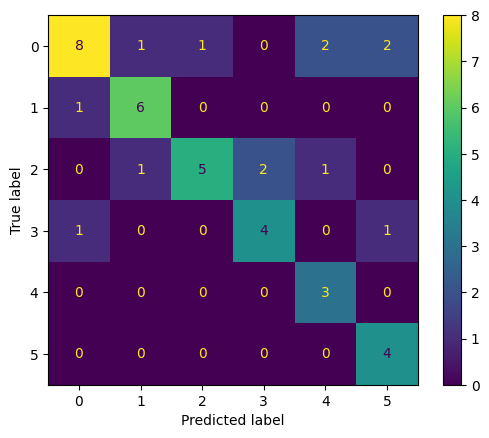

In [88]:
# C'est magique : grid_search_hgb se comporte comme le meilleur modèle trouvé
predictions = grid_search_hgb.predict(X_teclean_v2)  # Il utilise déjà les meilleurs paramètres !

# Tu peux afficher la matrice de confusion directement avec lui
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(grid_search_hgb, X_teclean_v2, y_teclean_v2)
plt.show()


Enregistrer mon modèle ( UNE SEULE FOIS) déja fait.

In [ ]:
import joblib

# 'mon_modele_lol.pkl' est le nom du fichier qui sera créé sur ton disque
# Tu peux choisir le nom que tu veux
# Sauvegarde uniquement le "gagnant" (plus léger)
#joblib.dump(grid_search_hgb.best_estimator_, 'mon_modele_lol.pkl')

print("Modèle sauvegardé avec succès !")

Modèle sauvegardé avec succès !


réutilisation de mon modèle 

In [90]:
# 1. On charge le fichier
modele_charge = joblib.load('mon_modele_lol.pkl')

# 2. C'est tout ! Il est prêt à l'emploi.
# Tu peux faire des prédictions immédiatement
prediction = modele_charge.predict(X_test)

print("Modèle chargé et prêt.")

NameError: name 'X_test' is not defined

Test sur nouveau champion

In [ ]:
import polars as pl

# 1. Créer les données du nouveau champion (valeurs brutes)
# Assure-toi de mettre TOUTES les colonnes utilisées lors de l'entraînement
nouveau_champ = pl.DataFrame({
    "hp": [550],
    "mp": [300],
    "attackdamage": [60],
    "armor": [30],
    "spellblock": [30],
    "spellblockperlevel": [0.5],
    # ... ajoute toutes les autres colonnes nécessaires ...
})

# 2. IMPORTANT : Refaire le Feature Engineering (ta formule magique)
# Le modèle a besoin de 'spellblocklvl', pas juste des deux autres séparés
nouveau_champ = nouveau_champ.with_columns(
    (pl.col("spellblock") + pl.col("spellblockperlevel") * 9).alias("spellblocklvl")
)

# 3. On sélectionne les colonnes finales dans le bon ordre (celui du X_train)
cols_entrainement = ["hp", "mp", "attackdamage", "armor", "spellblocklvl"] # Exemple, mets ta vraie liste
X_nouveau = nouveau_champ.select(cols_entrainement)

# 4. Prédiction
resultat = modele_charge.predict(X_nouveau)

print(f"Le rôle prédit est : {resultat[0]}")